#The task is to calculate credit risk RWA for the given data under both the standardized and IRB approach and compare the results.

# 1. Upload and clean the data.

In [1]:
# Standard library imports
import numpy as np
import pandas as pd

# Third-party library imports
import gspread
from google.auth import default
from google.colab import auth

# Authentication
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Open the workbook
worksheet = gc.open('Mortgage_default').sheet1
rows = worksheet.get_all_values()
column_names = rows[0]

# Create DataFrame
mortgage_default = pd.DataFrame.from_records(rows[1:], columns=column_names)

# Clean the data
mortgage_default = mortgage_default.apply(pd.to_numeric, errors='coerce')
null_rows = mortgage_default[mortgage_default['MORTDUE'].isnull()]
null_rows_index = null_rows.index
mortgage_default.drop(null_rows_index, inplace=True)

# Look at the table
mortgage_default

,BAD,MORTDUE,VALUE,ProfExeFlag,SalesFlag,SelfFlag,OtherFlag,MrgFlag,OffiseFlag,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,25860.0,39025.0,0,0,0,1,0,0,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,70053.0,68400.0,0,0,0,1,0,0,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,13500.0,16700.0,0,0,0,1,0,0,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
4,0,97800.0,112000.0,0,0,0,0,0,1,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
5,1,30548.0,40320.0,0,0,0,1,0,0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,0,0,0,1,0,0,16.0,0.0,0.0,221.808718,0.0,16.0,36.112347
5956,0,54576.0,92937.0,0,0,0,1,0,0,16.0,0.0,0.0,208.692070,0.0,15.0,35.859971
5957,0,54045.0,92924.0,0,0,0,1,0,0,15.0,0.0,0.0,212.279697,0.0,15.0,35.556590
5958,0,50370.0,91861.0,0,0,0,1,0,0,14.0,0.0,0.0,213.892709,0.0,16.0,34.340882


#2. Calculate credit risk RWA for the given data using the standardized approach.

In [ ]:
# Extract only those columns that are needed to calculate the standard approach
standard_approach_data = mortgage_default.loc[:, ['BAD', 'MORTDUE', 'VALUE']]

# Calculate LTV and fill the missing values
standard_approach_data['LTV'] = round(standard_approach_data['MORTDUE'] / standard_approach_data['VALUE'], 2)
standard_approach_data['LTV'] = standard_approach_data['LTV'].fillna(0.45)

# Calculate RW
def calculate_rw(row):
    if row['LTV'] <= 0.5:
        return 0.2
    elif 0.5 < row['LTV'] <= 0.6:
        return 0.25
    elif 0.6 < row['LTV'] <= 0.8:
        return 0.30
    elif 0.8 < row['LTV'] <= 0.9:
        return 0.40
    elif 0.9 < row['LTV'] <= 1:
        return 0.50
    elif row['LTV'] > 1:
        return 0.70
    else:
        return None

standard_approach_data['RW'] = standard_approach_data.apply(calculate_rw, axis=1)

# Add a single blank line here for readability

# Calculate RWA
standard_approach_data['RWA'] = round(standard_approach_data['MORTDUE'] * standard_approach_data['RW'], 2)

# Calculate EAD, RWA, and Capital Requirement for non-defaulted mortgages
not_defaulted_ead = standard_approach_data.loc[standard_approach_data['BAD'] == 0, 'MORTDUE'].sum()
formatted_not_defaulted_ead = '{:,.2f}'.format(not_defaulted_ead)
not_defaulted_rwa = standard_approach_data.loc[standard_approach_data['BAD'] == 0, 'RWA'].sum()
formatted_not_defaulted_rwa = '{:,.2f}'.format(not_defaulted_rwa)
not_defaulted_capital_req = round(not_defaulted_rwa * 0.08, 2)
formatted_not_defaulted_capital_req = '{:,.2f}'.format(not_defaulted_capital_req)
not_defaulted_rw = round(not_defaulted_rwa / not_defaulted_ead * 100, 2)

# Show the numbers
print('The EAD for non-defaulted mortgages is:', formatted_not_defaulted_ead, '\n')
print('The RWA for non-defaulted mortgages is:', formatted_not_defaulted_rwa, '\n')
print('The Capital Requirement for non-defaulted mortgages is:', formatted_not_defaulted_capital_req, '\n')
print('The RW for non-defaulted mortgages is:', not_defaulted_rw, '%', '\n')

# Show the table
standard_approach_data

The EAD for non-defaulted mortgages is: 326,180,696.63 

The RWA for non-defaulted mortgages is: 106,708,483.24 

The Capital Requirement for non-defaulted mortgages is: 8,536,678.66 

The RW for non-defaulted mortgages is: 32.71 % 



,BAD,MORTDUE,VALUE,LTV,RW,RWA
0,1,25860.0,39025.0,0.66,0.30,7758.00
1,1,70053.0,68400.0,1.02,0.70,49037.10
2,1,13500.0,16700.0,0.81,0.40,5400.00
4,0,97800.0,112000.0,0.87,0.40,39120.00
5,1,30548.0,40320.0,0.76,0.30,9164.40
...,...,...,...,...,...,...
5955,0,57264.0,90185.0,0.63,0.30,17179.20
5956,0,54576.0,92937.0,0.59,0.25,13644.00
5957,0,54045.0,92924.0,0.58,0.25,13511.25
5958,0,50370.0,91861.0,0.55,0.25,12592.50


#3. Test for multicollinearity

<ipython-input-2-ba16b687e92f>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(mortgage_default.corr(), dtype=np.bool))


<Axes: title={'center': 'Correlation Matrix'}>

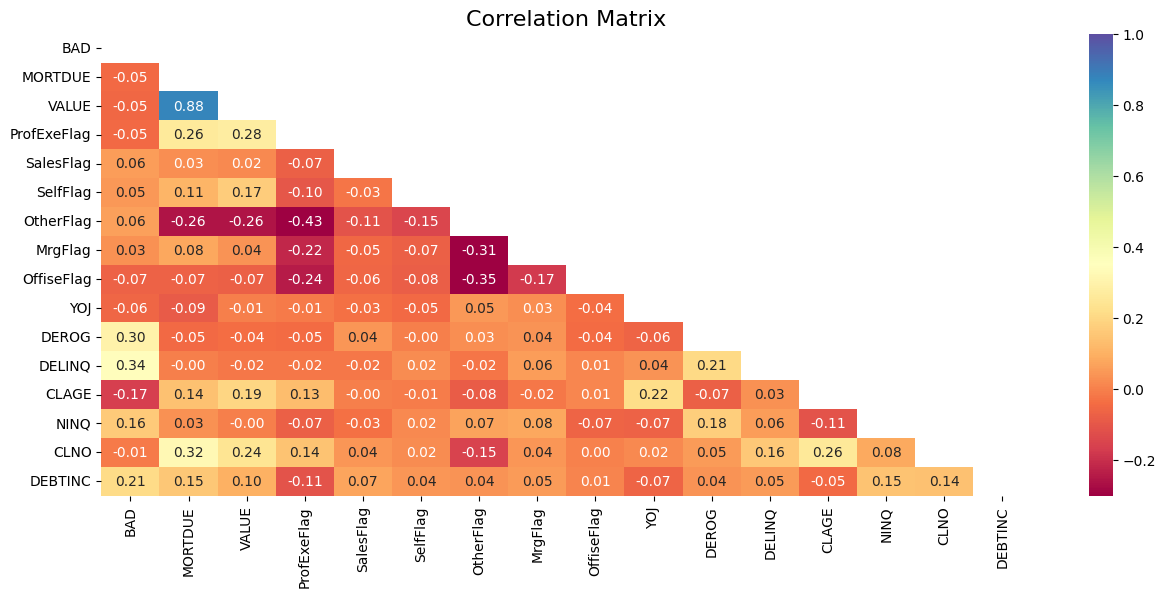

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the correlation matrix
plt.figure(figsize=(15, 6))
plt.title("Correlation Matrix", fontsize=16)

# Create a mask to hide the upper triangle for better visualization
mask = np.triu(np.ones_like(mortgage_default.corr(), dtype=np.bool))

# Use a heatmap to visualize the correlation matrix
sns.heatmap(
    mortgage_default.corr(),
    mask=mask,
    annot=True,
    vmin=-0.3,
    vmax=1,
    cmap="Spectral",
    fmt=".2f",  # Specify format for annotations
    annot_kws={"size": 10}  # Increase font size of annotations
)


#4. Reduce the impact of the large values by using the natural logarithm and fill the missing data with the means of that column

In [ ]:
# Data cleaning
mortgage_default['CLAGE'] = np.log1p(mortgage_default['CLAGE'])
mortgage_default['DEBTINC'] = np.log1p(mortgage_default['DEBTINC'])
mortgage_default.fillna(mortgage_default.mean(), inplace=True)

mortgage_default

,BAD,MORTDUE,VALUE,ProfExeFlag,SalesFlag,SelfFlag,OtherFlag,MrgFlag,OffiseFlag,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,25860.0,39025.0,0,0,0,1,0,0,10.5,0.0,0.0,4.557729,1.0,9.0,3.535720
1,1,70053.0,68400.0,0,0,0,1,0,0,7.0,0.0,2.0,4.810828,0.0,14.0,3.535720
2,1,13500.0,16700.0,0,0,0,1,0,0,4.0,0.0,0.0,5.013742,1.0,10.0,3.535720
4,0,97800.0,112000.0,0,0,0,0,0,1,3.0,0.0,0.0,4.546835,0.0,14.0,3.535720
5,1,30548.0,40320.0,0,0,0,1,0,0,9.0,0.0,0.0,4.629531,1.0,8.0,3.640572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,0,0,0,1,0,0,16.0,0.0,0.0,5.406314,0.0,16.0,3.613950
5956,0,54576.0,92937.0,0,0,0,1,0,0,16.0,0.0,0.0,5.345640,0.0,15.0,3.607126
5957,0,54045.0,92924.0,0,0,0,1,0,0,15.0,0.0,0.0,5.362604,0.0,15.0,3.598861
5958,0,50370.0,91861.0,0,0,0,1,0,0,14.0,0.0,0.0,5.370139,0.0,16.0,3.565040


#5. Create a logistic regression

In [ ]:
# Import libraries
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

# Add predictors and the outcome. Since there is a very strong correlation between MORTDUE and VALUE, these columns are excluded
predictors = mortgage_default[['ProfExeFlag','SelfFlag','OtherFlag','MrgFlag','OffiseFlag','YOJ','DEROG', 'DELINQ', 'CLAGE','NINQ', 'CLNO', 'DEBTINC']]
outcome = mortgage_default['BAD']

# Create and fit the logistic regresiion
logit_model = sm.Logit(outcome, predictors)
results = logit_model.fit()
aic = results.aic

# Display summary and AIC value
print(results.summary())
print('AIC value is:', aic)

Optimization terminated successfully.
         Current function value: 0.400359
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 5442
Model:                          Logit   Df Residuals:                     5430
Method:                           MLE   Df Model:                           11
Date:                Sun, 21 Jan 2024   Pseudo R-squ.:                  0.1977
Time:                        17:54:23   Log-Likelihood:                -2178.8
converged:                       True   LL-Null:                       -2715.7
Covariance Type:            nonrobust   LLR p-value:                2.415e-223
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ProfExeFlag     0.0618      0.189      0.327      0.743      -0.308       0.432
SelfFlag        0.5202    

#6. Use the logistic regression equation to calculate Odds Y=1 and the forecast

In [ ]:
# Multiply variables by their constants
mortgage_default['OddsY1'] = round(np.exp(
    (0.0618 * mortgage_default['ProfExeFlag']) +
    (0.5202 * mortgage_default['SelfFlag']) +
    (0.1912 * mortgage_default['OtherFlag']) +
    (0.0930 * mortgage_default['MrgFlag']) +
    (-0.4239 * mortgage_default['OffiseFlag']) +
    (-0.0130 * mortgage_default['YOJ']) +
    (0.6936 * mortgage_default['DEROG']) +
    (0.7037 * mortgage_default['DELINQ']) +
    (-0.8504 * mortgage_default['CLAGE']) +
    (0.1213 * mortgage_default['NINQ']) +
    (-0.0107 * mortgage_default['CLNO']) +
    (0.6655 * mortgage_default['DEBTINC'])
), 2)

# Calculate forecast
mortgage_default['Forecast'] = round(mortgage_default['OddsY1'] / (1 + mortgage_default['OddsY1']), 2)

mortgage_default


,BAD,MORTDUE,VALUE,ProfExeFlag,SalesFlag,SelfFlag,OtherFlag,MrgFlag,OffiseFlag,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,OddsY1,Forecast
0,1,25860.0,39025.0,0,0,0,1,0,0,10.5,0.0,0.0,4.557729,1.0,9.0,3.535720,0.24,0.19
1,1,70053.0,68400.0,0,0,0,1,0,0,7.0,0.0,2.0,4.810828,0.0,14.0,3.535720,0.68,0.40
2,1,13500.0,16700.0,0,0,0,1,0,0,4.0,0.0,0.0,5.013742,1.0,10.0,3.535720,0.17,0.15
4,0,97800.0,112000.0,0,0,0,0,0,1,3.0,0.0,0.0,4.546835,0.0,14.0,3.535720,0.12,0.11
5,1,30548.0,40320.0,0,0,0,1,0,0,9.0,0.0,0.0,4.629531,1.0,8.0,3.640572,0.25,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,57264.0,90185.0,0,0,0,1,0,0,16.0,0.0,0.0,5.406314,0.0,16.0,3.613950,0.09,0.08
5956,0,54576.0,92937.0,0,0,0,1,0,0,16.0,0.0,0.0,5.345640,0.0,15.0,3.607126,0.10,0.09
5957,0,54045.0,92924.0,0,0,0,1,0,0,15.0,0.0,0.0,5.362604,0.0,15.0,3.598861,0.10,0.09
5958,0,50370.0,91861.0,0,0,0,1,0,0,14.0,0.0,0.0,5.370139,0.0,16.0,3.565040,0.09,0.08


#7. Calculate credit risk RWA for the given data using the F-IRB approach.

In [ ]:
from scipy.stats import norm

# Extract only those columns needed for the IRB approach
irb_data = mortgage_default.loc[:, ['BAD', 'Forecast', 'MORTDUE']]

# Set constant values
irb_data['LGD'] = 0.45

# Calculate b, R, K, and RWA
irb_data['b'] = round((0.11852 - 0.05478 * np.log(irb_data['Forecast']))**2, 2)
irb_data['R'] = round(0.12 * ((1 - np.exp(-50 * irb_data['Forecast'])) / (1 - np.exp(-50))) +
                     0.24 * (1 - ((1 - np.exp(-50 * irb_data['Forecast'])) / (1 - np.exp(-50)))), 2)
irb_data['K'] = round((irb_data['LGD'] * norm.cdf((norm.ppf(irb_data['Forecast']) / np.sqrt(1 - irb_data['R'])) +
                   np.sqrt(1 - irb_data['R']) * norm.ppf(0.999)) -
                   irb_data['Forecast'] * irb_data['LGD']) * (1 / (1 - 1.5 * irb_data['b'])), 2)
irb_data['RWA'] = irb_data['K'] * 12.5 * irb_data['MORTDUE']

# Calculate EAD, RWA, Capital requirement, and RW for non-defaulted mortgages
irb_not_defaulted_ead = irb_data.loc[irb_data['BAD'] == 0, 'MORTDUE'].sum()
irb_formatted_not_defaulted_ead = '{:,.2f}'.format(irb_not_defaulted_ead)
irb_not_defaulted_rwa = irb_data.loc[irb_data['BAD'] == 0, 'RWA'].sum()
irb_formatted_not_defaulted_rwa = '{:,.2f}'.format(irb_not_defaulted_rwa)
irb_not_defaulted_capital_req = round(irb_not_defaulted_rwa * 0.08, 2)
irb_formatted_not_defaulted_capital_req = '{:,.2f}'.format(irb_not_defaulted_capital_req)
irb_not_defaulted_rw = round(irb_not_defaulted_rwa / irb_not_defaulted_ead * 100, 2)

# Print the values
print('The EAD for non-defaulted mortgages is:', irb_formatted_not_defaulted_ead, '\n')
print('The RWA for non-defaulted mortgages is:', irb_formatted_not_defaulted_rwa, '\n')
print('The Capital Requirement for non-defaulted mortgages is:', irb_formatted_not_defaulted_capital_req, '\n')
print('The RW for non-defaulted mortgages is:', irb_not_defaulted_rw, '%', '\n')

# Display the IRB approach data
irb_data

The EAD for non-defaulted mortgages is: 326,180,696.63 

The RWA for non-defaulted mortgages is: 1,589,211,706.17 

The Capital Requirement for non-defaulted mortgages is: 127,136,936.49 

The RW for non-defaulted mortgages is: 487.22 % 



,BAD,Forecast,MORTDUE,LGD,b,R,K,RWA
0,1,0.19,25860.0,0.45,0.04,0.12,0.38,122835.000
1,1,0.40,70053.0,0.45,0.03,0.12,0.28,245185.500
2,1,0.15,13500.0,0.45,0.05,0.12,0.40,67500.000
4,0,0.11,97800.0,0.45,0.06,0.12,0.41,501225.000
5,1,0.20,30548.0,0.45,0.04,0.12,0.37,141284.500
...,...,...,...,...,...,...,...,...
5955,0,0.08,57264.0,0.45,0.07,0.12,0.42,300636.000
5956,0,0.09,54576.0,0.45,0.06,0.12,0.41,279702.000
5957,0,0.09,54045.0,0.45,0.06,0.12,0.41,276980.625
5958,0,0.08,50370.0,0.45,0.07,0.12,0.42,264442.500


#Conclusions:

#1. The standardized approach is more "liberal" and requires less capital requirement than the F-IRB approach.
#2. The F-IRB approach is safer and prepares the bank for challenging times, although it requires more investment to fulfill.
#3. Although the F-IRB approach is safer for banks, it requires more time investment and in-depth knowledge of logistic regression model creation, good data storage, and collection.